# Trabalho Prático: Implementação de um Coletor Web

Integrantes: Guilherme Botelho
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ígor Chagas</p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Lucas Corrêa</p>

Orientador: Daniel Hasan Dalip

## Objetivo

O projeto proposto pelo professor tem como base a implementação de um coletor simples para Web, com o objetivo de estudar e aprender sua arquitetura. O coletor tem que obedecer, obrigatoriamente, os protocolos de exclusão de robôs:
- Critérios pertencentes no robots.txt;
- Critérios "noindex" e "nofollow" das metatags de cada html extraído;
- Obedecer o prazo de, no mínimo, 30 segundos entre requisições em um mesmo servidor;

Os parâmetros utilizados no trabalho, foram:
- Número máximo de páginas: 50.000 páginas
- Profundidade por domínio: 6  páginas
- Número de threads utilizado: 

## Sobre
Nosso coletor recebeu como nome *ri2020g3bot* e mais informações sobre ele podem ser entrcontradas em: https://daegonny.github.io/ri-tp1/

## URLs sementes utilizadas

Para realizar a coleta as urls de sementes utilizadas foram:

In [1]:
import pandas as pd

pd.read_csv('crawler/seeds.txt', header=None, names=['url'])

/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,url
0,http://cnn.com
1,http://www.gq.com.au/
2,https://www.huffpost.com/
3,http://www.globo.com/
4,https://pt.wikipedia.org/wiki/Wikip%C3%A9dia:P...
5,https://globoesporte.globo.com/
6,https://www.espn.com.br/
7,https://www.foxnews.com/
8,https://www.bbc.com/
9,https://www.reddit.com/


## Principais desafios

Os principais desafios encontrados para a realização do coletor foram relacionados a otimização do tempo de processamento do mesmo e o uso dos recursos pelos processos (threads).

Percebemos durante a implementação que a relação entre o tempo de espera, número de processos em paralelo e número de URLs sementes eram primordial para o desempenho do coletor que acarretou algumas decisões de implementações que serão abordadas a seguir. 

## Decisões e arquitetura utilizada

Para o desenvolvimento do coletor foram implementadas algumas funcionalidades no intuito de resolver os problema comentados anteriormente, garantindo a qualidade e perfomace do coletor. As principais considerações são:

### Classe Domain (Domínio)

A classe domain que é responsável pela estruturação do dominios quais o coletor poderá acessar foi adicionada uma propriedade calculada que é `time_will_be_acessible` que possui a responsabilidade de armazenar o horário qual aquele domínio se tornará acessível novamente para realizar uma nova coleta.

Além de algumas propriedade básicas `accessed_now`, `time_since_last_access`, `is_accessible` que calculam o momento que o domínio foi acessado, o tempo desde o último acesso e se o domínio é acessível, respectivamente.

Alguns métodos built-in de classes Python (`__hash__`, `__eq__`, `__str__`, `__repr__`) foram implementadas para auxiliar nos processos de comparação, criação de dicionário e exibição do objetos
   

### Classe Scheduler (Escalonador)
A classe Scheduler que possui a responsabilidade de orquestrar as coletas foram desenvolvidas alguns métodos principais para a execução do processo, entre eles foram:

#### get_next_url
Método para obtenção para da próxima URL, caso exista, a ser coletada. Para isso o seguinte algoritmo foi implementado.

- Para cada domínio presente no coletor é verificado se o mesmo está acessível. 
    - Caso verdadeiro a URL é marcada como acessada, removida do Scheduler e retorna o método retorna URL e sua profundidade atual
- Caso nenhuma URL seja acessível é calculada o menor tempo para o próximo dominio ficar disponível através do método `Domain.time_will_be_acessible` e deixa o processo em espera até esse tempo seja atingido.

Esse processo é executado até o escalonador não possuir mais domínios a serem acessados.

#### add_new_page
Método que adiciona uma nova página ao escalonador desde que atenda aos seguintes critérios:
- Profundidade máxima do domínio ainda não foi atingida
- URL ainda não foi descoberta

Com os critérios atingidos essa função adiciona o URL ao dicionário de domínios.


#### has_finished_crawl
Método que verifica se os critérios de parada do escalonador foram atingidos.


### Classe Page Fetcher
Classe que irá realizar as ações de coletas dos páginas. Esse classe será executada em paralelo, portanto ela irá herdar da classe Thread do Python.

Os principais métodos para execução dessa classe são:

#### crawl_new_url
Realiza a coleta da nova URL vinda do metodo `Scheduler.get_next_url` e com base nela é realizado o seguinte fluxo: 

- Caso nenhuma URL seja retornada a coleta é encerrada.
- Caso os critérios de parada tenham sido atingidos a coleta é encerrada
- Caso a coleta não tenha sido encerrada a página é requisitada e checado os seguintes critérios:
 - Se a pagina permite indexação, atraves do método (`has_no_index`),  se sim a URL é armazenada (`collect`)
 - Se a página permite seguir os links, através do método (`has_no_follow`), se sim os links são descobertos e adicionados a fila do escalonador (`gather_links`).

#### has_no_index
Realiza a verificação do tag meta `noindex` na pagina HTML obitida


#### has_no_follow
Realiza a verificação do tag meta `nofollow` na pagina HTML obitida

#### gather_links
A partir da página HTML acessada é feito a procura por `tags a` e descoberta a URL absoluta dos mesmos e qual será a profundidade do link encontrado.

A partir disso é adicionado ao escalonador o link com sua profundidade.

#### collect
O método `collect` adiciona o a URL requisitada a lista de URLs encontradas.

## Avaliação dos resultados

### Execução do coletor

In [2]:
from crawler.report import Report
import pandas as pd

report = Report()

report.run_crawler(int_page_limit=20, int_depth_limit=6, n_threads=5)
pd.read_csv('crawler/urls.txt', header=None, names=['url'])

next ParseResult(scheme='http', netloc='cnn.com', path='', params='', query='', fragment='')
coletado http://cnn.com


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/daegonny/code/python/ri/ri-tp1/crawler/page_fetcher.py", line 110, in run
    self.crawl_new_url()
  File "/home/daegonny/code/python/ri/ri-tp1/crawler/page_fetcher.py", line 54, in crawl_new_url
    url, depth, time_to_wait = self.obj_scheduler.get_next_url()
  File "/home/daegonny/code/python/ri/ri-tp1/util/threads.py", line 9, in synced_func
    return func(*args, **kws)
  File "/home/daegonny/code/python/ri/ri-tp1/crawler/scheduler.py", line 109, in get_next_url
    for domain, urls in self.dic_url_per_domain.items():
RuntimeError: OrderedDict mutated during iteration


removed www.gq.com.au
removed www.huffpost.com
next ParseResult(scheme='http', netloc='www.globo.com', path='/', params='', query='', fragment='')
coletado http://www.globo.com/
next ParseResult(scheme='https', netloc='pt.wikipedia.org', path='/wiki/Wikip%C3%A9dia:P%C3%A1gina_principal', params='', query='', fragment='')
next ParseResult(scheme='https', netloc='globoesporte.globo.com', path='/', params='', query='', fragment='')
next ParseResult(scheme='https', netloc='www.espn.com.br', path='/', params='', query='', fragment='')
next ParseResult(scheme='https', netloc='www.foxnews.com', path='/', params='', query='', fragment='')
coletado https://globoesporte.globo.com/
next ParseResult(scheme='https', netloc='www.bbc.com', path='/', params='', query='', fragment='')
coletado https://pt.wikipedia.org/wiki/Wikip%C3%A9dia:P%C3%A1gina_principal
coletado https://www.bbc.com/
coletado https://www.espn.com.br/
coletado https://www.foxnews.com/
next ParseResult(scheme='https', netloc='www.re

,url
0,http://cnn.com
1,http://www.globo.com/
2,https://globoesporte.globo.com/
3,https://pt.wikipedia.org/wiki/Wikip%C3%A9dia:P...
4,https://www.bbc.com/
5,https://www.espn.com.br/
6,https://www.foxnews.com/
7,https://www.reddit.com/
8,https://www.nbcnews.com/
9,https://abcnews.go.com/


### Análise de velocidade

Com o objetivo de realizar uma análise da velocidade do coletor baseado no número de threads foi realizado o seguinte teste:

- Aumento do número de threads de 10 a 110, com o aumento de 20 em 20 threads
- Lista de sementes mostrada acima
- Limite de profundidade: 6
- Número limite de página visitadas: 50000

Com isso pode-se observar o seguinte resultado:

Exception in thread Thread-517:
Traceback (most recent call last):
  File "/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-packages/urllib3/connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-packages/urllib3/connectionpool.py", line 381, in _make_request
    self._validate_conn(conn)
  File "/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-packages/urllib3/connectionpool.py", line 978, in _validate_conn
    conn.connect()
  File "/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-packages/urllib3/connection.py", line 362, in connect
    self.sock = ssl_wrap_socket(
  File "/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-packages/urllib3/util/ssl_.py", line 384, in ssl_wrap_socket
    return context.wrap_socket(sock, server_hostname=server_hostname)
  File "/Users/lucascorrea/.pyenv/versions/3.8.0/lib/python3.8/ssl.py", line 500, in wrap_socket
    retur

Finished with 0:02:47.781230
Finished with 0:02:38.935981


Exception in thread Thread-563:
Traceback (most recent call last):
  File "/Users/lucascorrea/.pyenv/versions/3.8.0/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/lucascorrea/dev/projects/ri-tp1/crawler/page_fetcher.py", line 102, in run
    self.crawl_new_url()
  File "/Users/lucascorrea/dev/projects/ri-tp1/crawler/page_fetcher.py", line 60, in crawl_new_url
    response = self.request_url(url)
  File "/Users/lucascorrea/dev/projects/ri-tp1/crawler/page_fetcher.py", line 22, in request_url
    response = requests.get(obj_url.geturl(), headers={
  File "/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-p

Exception in thread Thread-599:
Traceback (most recent call last):
  File "/Users/lucascorrea/.pyenv/versions/3.8.0/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/lucascorrea/dev/projects/ri-tp1/crawler/page_fetcher.py", line 102, in run
    self.crawl_new_url()
  File "/Users/lucascorrea/dev/projects/ri-tp1/crawler/page_fetcher.py", line 60, in crawl_new_url
    response = self.request_url(url)
  File "/Users/lucascorrea/dev/projects/ri-tp1/crawler/page_fetcher.py", line 22, in request_url
    response = requests.get(obj_url.geturl(), headers={
  File "/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-p

Finished with 0:02:51.517010
Finished with 0:03:19.915224


Exception in thread Thread-677:
Traceback (most recent call last):
  File "/Users/lucascorrea/.pyenv/versions/3.8.0/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/lucascorrea/dev/projects/ri-tp1/crawler/page_fetcher.py", line 102, in run
    while not self.obj_scheduler.has_finished_crawl() and not self.finished:
  File "/Users/lucascorrea/dev/projects/ri-tp1/crawler/page_fetcher.py", line 60, in crawl_new_url
    if(url != None and not self.obj_scheduler.has_finished_crawl() and can_fetch_page):
  File "/Users/lucascorrea/dev/projects/ri-tp1/crawler/page_fetcher.py", line 22, in request_url
    response = requests.get(obj_url.geturl(), headers={
  File "/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.reques

Exception in thread Thread-707:
Traceback (most recent call last):
  File "/Users/lucascorrea/.pyenv/versions/3.8.0/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/lucascorrea/dev/projects/ri-tp1/crawler/page_fetcher.py", line 102, in run
    """
  File "/Users/lucascorrea/dev/projects/ri-tp1/crawler/page_fetcher.py", line 60, in crawl_new_url
    return
  File "/Users/lucascorrea/dev/projects/ri-tp1/crawler/page_fetcher.py", line 22, in request_url
    try:
  File "/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/Users/lucascorrea/.virtualenvs/ri-tp1/lib/python3.8/site-packages/requests/sessions.py", line 530, in request
    resp = self.send(prep, **send_kwar

Finished with 0:03:04.777191


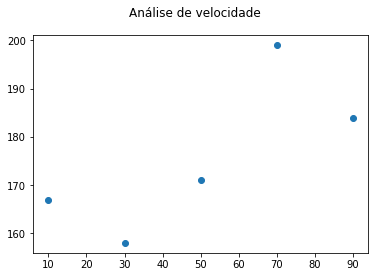

In [5]:
report.velocity_result(int_page_limit=500, int_depth_limit=6)

In [ ]:
report.velocity_result(int_page_limit=500, int_depth_limit=6)

## Considerações finais

